   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires requests==2.32.

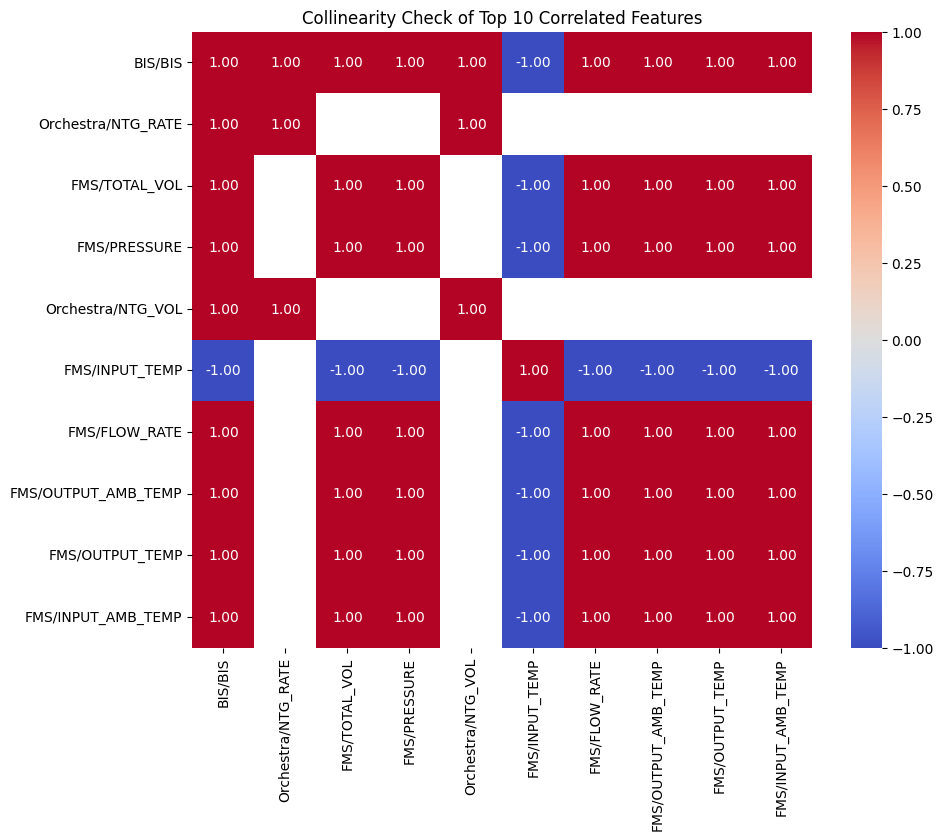

In [1]:
# --- Standalone Script: Comprehensive Correlation (Reliable Logging) ---

# Step 1: Install necessary libraries
!pip install vitaldb pandas numpy seaborn matplotlib awscli --quiet
print("--- Libraries installed ---")

import vitaldb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import subprocess
import warnings

# Ignore common runtime warnings from pandas/vitaldb when processing messy data
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Configuration ---
SAMPLE_CASE_IDS = list(range(1, 1001))
LOG_INTERVAL = 10 # Print an update every 20 files

# --- Function to process a single case ---
def process_case(case_id):
    """
    Downloads, processes, and cleans up a single vital file for a given case_id.
    """
    padded_id = f"{case_id:04d}"
    s3_path = f"s3://physionet-open/vitaldb/1.0.0/vital_files/{padded_id}.vital"
    local_file = f"{padded_id}.vital"

    try:
        command = ["aws", "s3", "cp", "--no-sign-request", s3_path, local_file]
        subprocess.run(command, check=True, capture_output=True, text=True)

        if not os.path.exists(local_file):
            return None

        vf = vitaldb.VitalFile(local_file)
        track_names = vf.get_track_names()
        numeric_tracks = [name for name in track_names if '_WAV' not in name and 'EVENT' not in name]

        if not numeric_tracks:
            return None

        df = vf.to_pandas(track_names=numeric_tracks, interval=1)

        if 'BIS/BIS' in df.columns:
            df = df[(df['BIS/BIS'] >= 1) & (df['BIS/BIS'] <= 100)]

        if df.empty:
            return None

        patient_means = df.mean(numeric_only=True).to_dict()
        patient_means['caseid'] = case_id
        return patient_means

    except subprocess.CalledProcessError:
        return None
    except Exception as e:
        return None
    finally:
        if os.path.exists(local_file):
            os.remove(local_file)

# --- Main Execution ---
print(f"Starting analysis on {len(SAMPLE_CASE_IDS)} sample cases using the ROBUST download method.")
all_patient_data = []

# THE FIX: Use a simple loop with periodic print statements
for i, case_id in enumerate(SAMPLE_CASE_IDS):
    patient_summary = process_case(case_id)
    if patient_summary:
        all_patient_data.append(patient_summary)
    
    # Print a log message at specified intervals
    if (i + 1) % LOG_INTERVAL == 0:
        print(f"--- Processed {i + 1} / {len(SAMPLE_CASE_IDS)} files ---")

print(f"\n--- Loop finished. Processed {len(SAMPLE_CASE_IDS)} total files. ---")
print(f"Successfully extracted data from {len(all_patient_data)} cases.")

# --- Final Analysis ---
if all_patient_data:
    full_aggregated_df = pd.DataFrame(all_patient_data)
    full_aggregated_df.set_index('caseid', inplace=True)

    print("\nCalculating comprehensive correlation matrix...")
    comprehensive_corr_matrix = full_aggregated_df.corr()

    if 'BIS/BIS' in comprehensive_corr_matrix:
        bis_correlations = comprehensive_corr_matrix['BIS/BIS'].dropna()
        non_null_counts = full_aggregated_df.notna().sum()
        results_df = pd.DataFrame({
            'Correlation': bis_correlations,
            'PatientCount': non_null_counts
        }).dropna().sort_values(by='Correlation', ascending=False)

        print("\n--- Top 20 Most Correlated Features with BIS/BIS (with Patient Counts) ---")
        print(results_df.head(20))

        print("\n--- Top 20 Most Negatively Correlated Features with BIS/BIS (with Patient Counts) ---")
        print(results_df.tail(20))

        results_df.to_csv('comprehensive_bis_correlations_with_counts.csv')
        print("\nSaved full correlation list with counts to 'comprehensive_bis_correlations_with_counts.csv'")

        print("\n--- Collinearity Check: Correlation Matrix of Top 10 Features ---")
        top_features_by_corr = results_df['Correlation'].abs().sort_values(ascending=False).head(10).index
        collinearity_matrix = comprehensive_corr_matrix.loc[top_features_by_corr, top_features_by_corr]
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(collinearity_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Collinearity Check of Top 10 Correlated Features')
        plt.show()

    else:
        print("\n'BIS/BIS' track not found in the processed data to calculate correlations.")
else:
    print("No data was successfully processed.")